In [37]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from prophet import Prophet

# Load the dataset
df = pd.read_csv('netflixVSyoutube.csv', skiprows=1)
print(df.head())

         Week  netflix: (Worldwide)  youtube: (Worldwide)
0  2018-12-30                    20                    98
1  2019-01-06                    17                    93
2  2019-01-13                    16                    95
3  2019-01-20                    16                    96
4  2019-01-27                    16                    97


In [38]:
# Rename columns (since you skipped the header row)
df.columns = ['Week', 'Netflix', 'YouTube']

# Convert 'Week' to datetime
df['Week'] = pd.to_datetime(df['Week'])

# Check for missing values
print("Missing values:\n", df.isnull().sum())

Missing values:
 Week       0
Netflix    0
YouTube    0
dtype: int64


In [39]:
# Use IQR to detect outliers
Q1 = df[['Netflix', 'YouTube']].quantile(0.25)
Q3 = df[['Netflix', 'YouTube']].quantile(0.75)
IQR = Q3 - Q1
df_clean = df[~((df[['Netflix','YouTube']]<(Q1 - 1.5 * IQR))|(df[['Netflix','YouTube']]>(Q3 + 1.5 * IQR))).any(axis=1)]
print(f"Original rows: {len(df)} | Cleaned rows: {len(df_clean)}")

Original rows: 157 | Cleaned rows: 148


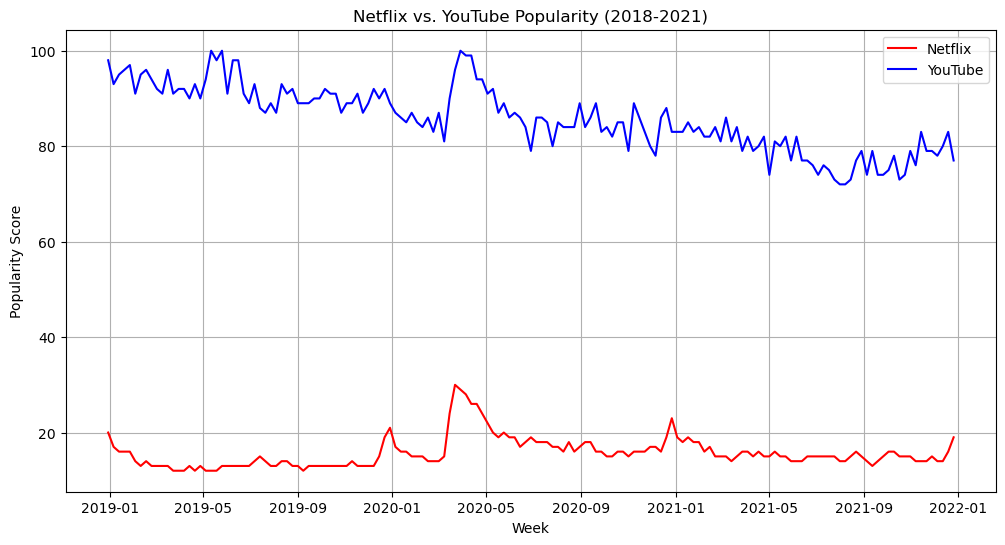

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(df['Week'], df['Netflix'], label='Netflix', color='red')
plt.plot(df['Week'], df['YouTube'], label='YouTube', color='blue')
plt.title("Netflix vs. YouTube Popularity (2018-2021)")
plt.xlabel("Week")
plt.ylabel("Popularity Score")
plt.legend()
plt.grid()
plt.show()

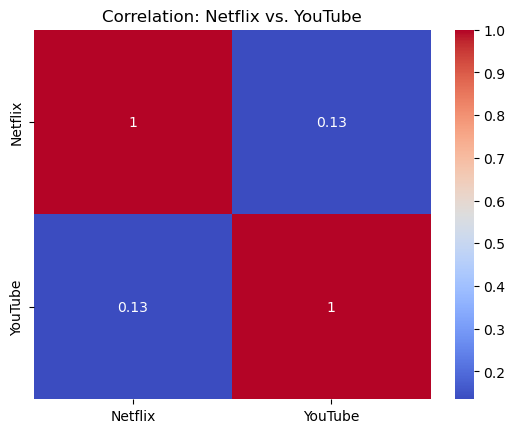

In [41]:
sns.heatmap(df[['Netflix', 'YouTube']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation: Netflix vs. YouTube")
plt.show()

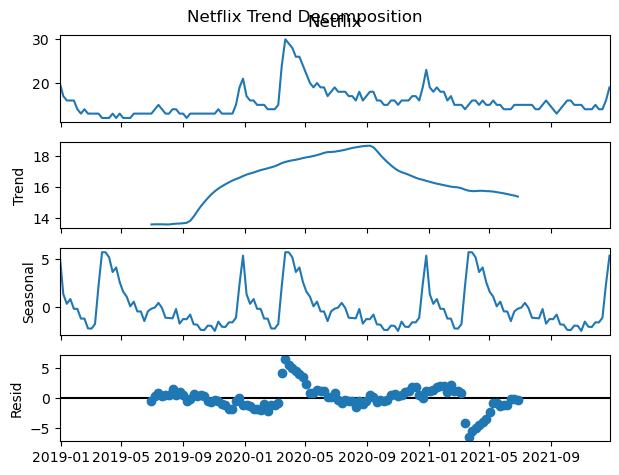

In [42]:
# Decompose Netflix trends
netflix_ts = df.set_index('Week')['Netflix']
decomposition = seasonal_decompose(netflix_ts, model='additive', period=52)  # Weekly data
decomposition.plot()
plt.suptitle("Netflix Trend Decomposition")
plt.show()

In [43]:
# Fit ARIMA model for Netflix
model = ARIMA(df['Netflix'], order=(1, 1, 1))  # Example parameters (adjust as needed)
results = model.fit()
print(results.summary())

# Forecast next 10 weeks
forecast = results.get_forecast(steps=10)
forecast_mean = forecast.predicted_mean
print("Forecasted Netflix values:\n", forecast_mean)

                               SARIMAX Results                                
Dep. Variable:                Netflix   No. Observations:                  157
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -275.909
Date:                Thu, 31 Jul 2025   AIC                            557.819
Time:                        16:55:38   BIC                            566.968
Sample:                             0   HQIC                           561.535
                                - 157                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2102      0.270     -0.778      0.437      -0.740       0.319
ma.L1          0.4549      0.280      1.628      0.104      -0.093       1.003
sigma2         2.0116      0.106     18.985      0.0

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


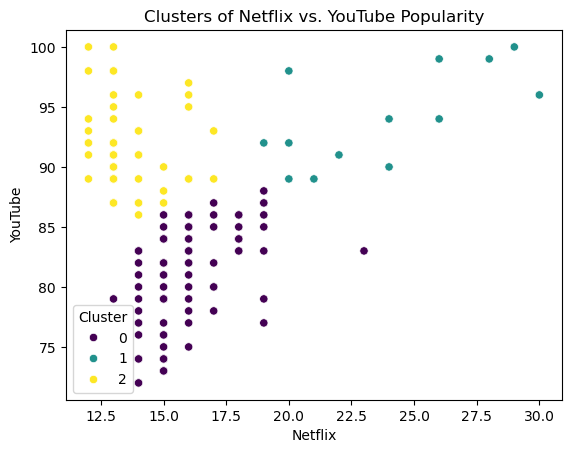

Silhouette Score: 0.50


In [47]:
from sklearn.preprocessing import MinMaxScaler

# Normalize data
scaler = MinMaxScaler()
X = scaler.fit_transform(df[['Netflix', 'YouTube']])

# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

# Visualize clusters
sns.scatterplot(data=df, x='Netflix', y='YouTube', hue='Cluster', palette='viridis')
plt.title("Clusters of Netflix vs. YouTube Popularity")
plt.show()

# Silhouette score
print(f"Silhouette Score: {silhouette_score(X, df['Cluster']):.2f}")

17:02:35 - cmdstanpy - INFO - Chain [1] start processing
17:02:35 - cmdstanpy - INFO - Chain [1] done processing


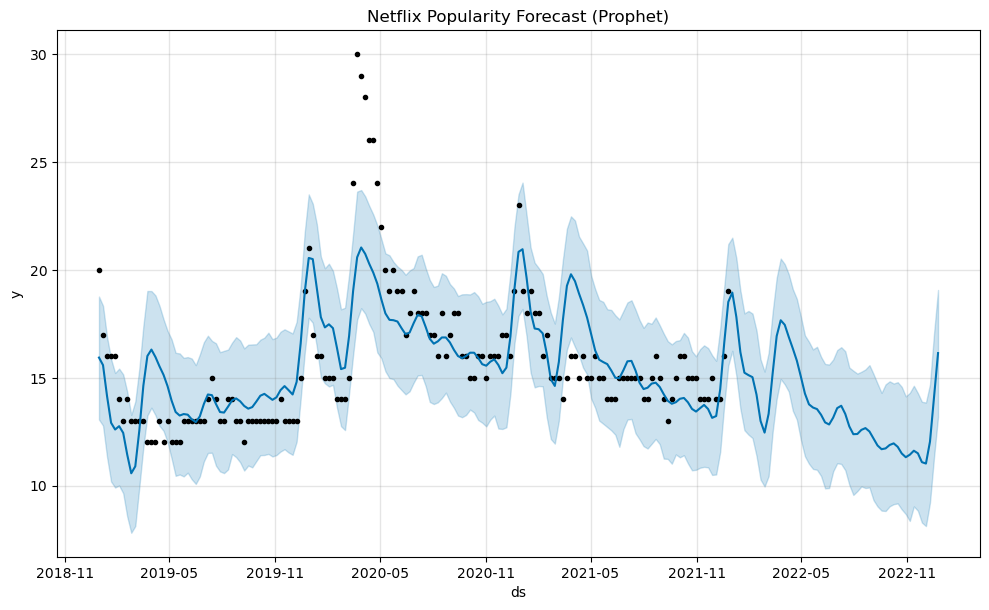

In [48]:
# Prepare data for Prophet
prophet_df = df[['Week', 'Netflix']].rename(columns={'Week': 'ds', 'Netflix': 'y'})

# Fit model
model = Prophet()
model.fit(prophet_df)

# Forecast
future = model.make_future_dataframe(periods=52, freq='W')  # 52 weeks ahead
forecast = model.predict(future)
model.plot(forecast)
plt.title("Netflix Popularity Forecast (Prophet)")
plt.show()

In [49]:
# Weeks where Netflix and YouTube popularity are closest (high competition)
df['Competition_Index'] = abs(df['Netflix'] - df['YouTube'])
high_comp_weeks = df.nsmallest(10, 'Competition_Index')
print("Top 10 High-Competition Weeks:\n", high_comp_weeks[['Week', 'Netflix', 'YouTube']])

Top 10 High-Competition Weeks:
           Week  Netflix  YouTube
134 2021-07-25       15       73
135 2021-08-01       14       72
136 2021-08-08       14       72
137 2021-08-15       15       73
146 2021-10-17       15       73
156 2021-12-26       19       77
122 2021-05-02       15       74
131 2021-07-04       15       74
143 2021-09-26       15       74
144 2021-10-03       16       75


In [50]:
# Compare average popularity pre/during/post-pandemic
df['Year'] = df['Week'].dt.year
pandemic_impact = df.groupby('Year')[['Netflix', 'YouTube']].mean()
print("Pandemic Impact:\n", pandemic_impact)

Pandemic Impact:
         Netflix    YouTube
Year                      
2018  20.000000  98.000000
2019  13.576923  91.903846
2020  18.288462  86.480769
2021  15.326923  78.692308


In [51]:
# Save cleaned data with clusters/forecasts
df.to_csv('netflix_youtube_analyzed.csv', index=False)